In [5]:
from sktime.datasets import load_UCR_UEA_dataset
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sktime.transformations.compose import FitInTransform
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sktime.transformations.panel.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sktime.transformations.panel.dictionary_based import PAAlegacy
from sklearn.metrics import classification_report
from sktime.classification.shapelet_based import ShapeletTransformClassifier
from sklearn.tree import DecisionTreeClassifier
from sktime.transformations.panel.shapelet_transform import RandomShapeletTransform
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

from sktime.dists_kernels.dtw import DtwDist

In [7]:
def load_npy(filename):
    return np.load(filename)

dir_path = 'dataset/time_series/'
len_threshold = 1280

X, y, ids = [], [], []

for file in os.listdir(dir_path):
    if os.path.splitext(file)[1] != '.npy':
        continue

    split = file.split("_")
    ids.append(split[0]) # track_id
    y.append(split[1][:-4]) # genre
    ts = load_npy(dir_path + file)
    
    if len(ts) > len_threshold:
        ts = ts[0:len_threshold]
    else:
        # pad = [np.mean(ts[:-5])] * (len_threshold-len(ts)) # fill by mean value of last n observations
        pad = [ts[-1]] * (len_threshold-len(ts)) # fill with last observation
        ts = np.append(ts, pad) 

    X.append([ts])

X, y, ids = np.array(X), np.array(y), np.array(ids)

In [8]:
df_ts = pd.DataFrame(np.squeeze(X))
df_ts["genre"] = y
df_ts["id"] = ids

In [9]:
#Loading distance matrix (for PAA 128) calculated with
#d = DtwDist(weighted=False, derivative=False)
#dist_mat_paa = d.transform(X_paa)

dist_mat_paa = np.load('dist_mat_paa.npy')

In [12]:
%%time
paa = PAAlegacy(64)
X_paa = paa.fit_transform(X)
X_paa.shape

CPU times: total: 2.73 s
Wall time: 4.28 s


(10000, 1, 64)

In [6]:
%%time

d = DtwDist(weighted=False, derivative=False)
dist_mat_paa64 = d.transform(X_paa)

CPU times: user 21min 6s, sys: 19 s, total: 21min 25s
Wall time: 21min 50s


In [ ]:
np.save('dist_mat_paa64', dist_mat_paa)

## Splitting the data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X_paa, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 1, 64), (2000, 1, 64), (8000,), (2000,))

## kNN

In [17]:
knn = KNeighborsTimeSeriesClassifier(n_neighbors=28, distance="dtw")

In [18]:
%%time
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

              emo       0.10      0.04      0.06       100
             folk       0.12      0.11      0.12       100
             goth       0.16      0.14      0.15       100
            happy       0.33      0.48      0.39       100
      heavy-metal       0.21      0.54      0.30       100
       honky-tonk       0.19      0.40      0.26       100
           j-idol       0.19      0.33      0.24       100
             kids       0.25      0.11      0.15       100
   minimal-techno       0.29      0.20      0.24       100
              mpb       0.15      0.08      0.10       100
          new-age       0.37      0.54      0.44       100
            opera       0.16      0.14      0.15       100
            piano       0.57      0.44      0.50       100
progressive-house       0.32      0.22      0.26       100
            salsa       0.15      0.12      0.13       100
        sertanejo       0.17      0.28      0.21       

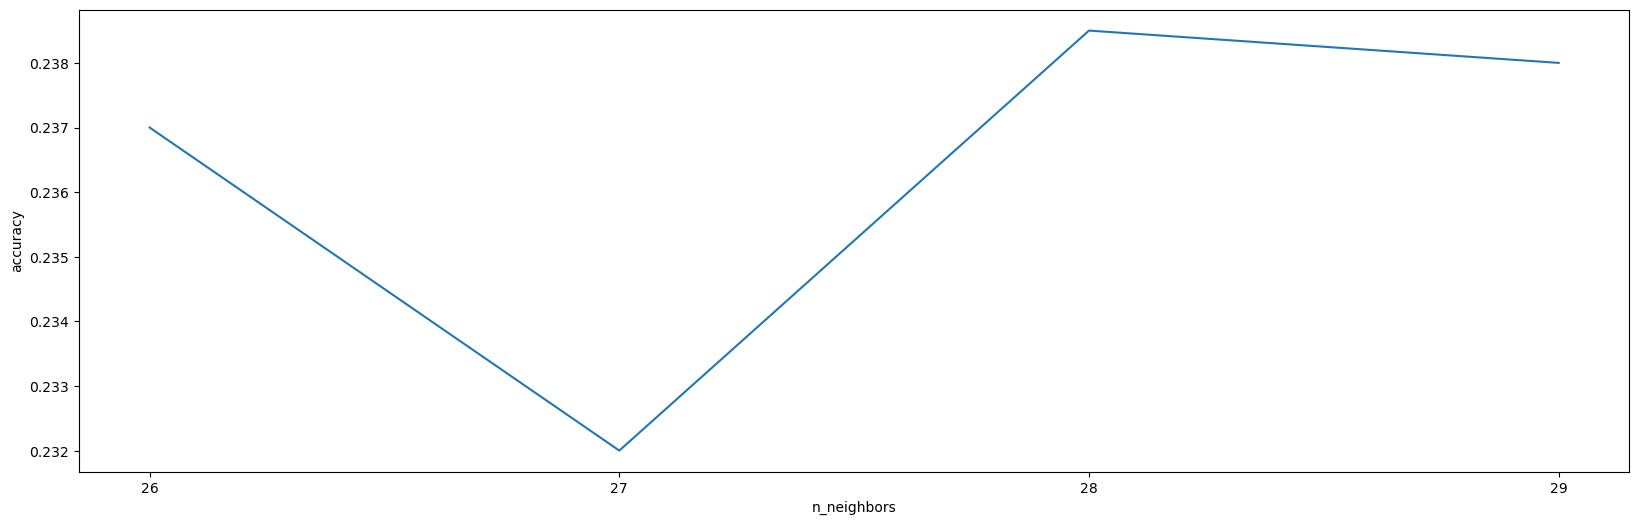

CPU times: user 2min 50s, sys: 2.36 s, total: 2min 52s
Wall time: 2min 58s


In [16]:
%%time

n_neighbors = range(26,30)
scores = list()

for n in n_neighbors:
    clf = KNeighborsTimeSeriesClassifier(n_neighbors=n, distance="dtw")
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

fig = plt.figure(figsize=(20, 6))

plt.plot(scores)
plt.xticks(range(len(n_neighbors)), n_neighbors)
plt.xlabel("n_neighbors")
plt.ylabel("accuracy")
plt.show()

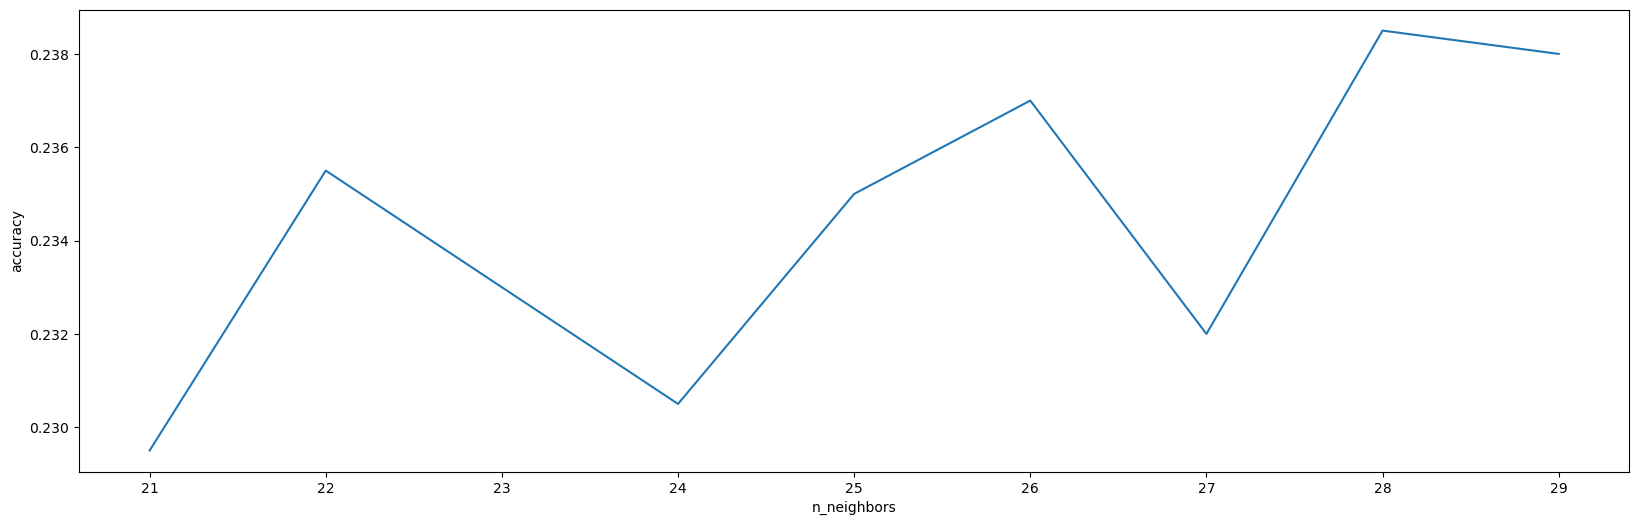

CPU times: user 6min 35s, sys: 3.61 s, total: 6min 39s
Wall time: 6min 46s


In [28]:
%%time

n_neighbors = range(21,30)
scores = list()

for n in n_neighbors:
    clf = KNeighborsTimeSeriesClassifier(n_neighbors=n, distance="dtw")
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

fig = plt.figure(figsize=(20, 6))

plt.plot(scores)
plt.xticks(range(len(n_neighbors)), n_neighbors)
plt.xlabel("n_neighbors")
plt.ylabel("accuracy")
plt.show()

## Shapelet transform

### All together

In [16]:
st = ShapeletTransformClassifier()

In [18]:
%%time
st.fit(X_train, y_train)
y_pred = st.predict(X_test)
print(classification_report(y_test, y_pred))

KeyboardInterrupt: 

### Decomposed

In [27]:
rst = RandomShapeletTransform(n_shapelet_samples=100, max_shapelets=None, min_shapelet_length=3,
                               max_shapelet_length=None, n_jobs=20) #n_jobs -1 uses all processors

In [ ]:
%%time
rst.fit(X_train, y_train)

In [26]:
%%time
shapelets_distances_train = rst.transform(X_train)
shapelets_distances_test = rst.transform(X_test)

CPU times: user 1min 9s, sys: 19 s, total: 1min 28s
Wall time: 1min 31s


In [27]:
%%time
clf = DecisionTreeClassifier()
clf = clf.fit(shapelets_distances_train, y_train)
y_pred = clf.predict(shapelets_distances_test)
print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

              emo       0.11      0.10      0.11       100
             folk       0.07      0.08      0.08       100
             goth       0.07      0.07      0.07       100
            happy       0.11      0.11      0.11       100
      heavy-metal       0.07      0.06      0.06       100
       honky-tonk       0.03      0.03      0.03       100
           j-idol       0.09      0.08      0.08       100
             kids       0.04      0.04      0.04       100
   minimal-techno       0.10      0.10      0.10       100
              mpb       0.05      0.04      0.04       100
          new-age       0.09      0.10      0.09       100
            opera       0.03      0.03      0.03       100
            piano       0.17      0.17      0.17       100
progressive-house       0.14      0.12      0.13       100
            salsa       0.04      0.04      0.04       100
        sertanejo       0.15      0.15      0.15       